In [73]:
# import required libraries
import pandas as pd
import numpy as np
import json
import requests
import seaborn as sns
import folium
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from geopy.geocoders import Nominatim

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Xgboost
import xgboost as xgb
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree

# NYC Venues Clustering

First, I'll use the Foursquare API to create clusters according to most common venues in NYC

In [8]:
# !wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

In [9]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods_data = newyork_data['features']

In [10]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [2]:
# download the data from http://insideairbnb.com/get-the-data.html
# city New York
# http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/listings.csv.gz
# and loat it to a dataframe

df0 = pd.read_csv('./data/listings.csv',low_memory=False)
df0.head()


id                        listing_url       scrape_id last_scraped  \
0  2595  https://www.airbnb.com/rooms/2595  20191204162729   2019-12-07   
1  3831  https://www.airbnb.com/rooms/3831  20191204162729   2019-12-07   
2  5099  https://www.airbnb.com/rooms/5099  20191204162729   2019-12-06   
3  5121  https://www.airbnb.com/rooms/5121  20191204162729   2019-12-06   
4  5178  https://www.airbnb.com/rooms/5178  20191204162729   2019-12-05   

                                        name  \
0                      Skylit Midtown Castle   
1            Cozy Entire Floor of Brownstone   
2  Large Cozy 1 BR Apartment In Midtown East   
3                            BlissArtsSpace!   
4           Large Furnished Room Near B'way    

                                             summary  \
0  Beautiful, spacious skylit studio in the heart...   
1  Urban retreat: enjoy 500 s.f. floor in 1899 br...   
2  My large 1 bedroom apartment has a true New Yo...   
3                                                NaN   
4  Please don’t expect the luxury here just a bas...   

                                               space  \
0  - Spacious (500+ft²), immaculate and nicely fu...   
1  Greetings!      We own a double-duplex brownst...   
2  I have a large 1 bedroom apartment centrally l...   
3  HELLO EVERYONE AND THANKS FOR VISITING BLISS A...   
4  You will use one large, furnished, private roo...   

                                         description experiences_offered  \
0  Beautiful, spacious skylit studio in the heart...                none   
1  Urban retreat: enjoy 500 s.f. floor in 1899 br...                none   
2  My large 1 bedroom apartment has a true New Yo...                none   
3  HELLO EVERYONE AND THANKS FOR VISITING BLISS A...                none   
4  Please don’t expect the luxury here just a bas...                none   

                               neighborhood_overview  ... instant_bookable  \
0  Centrally located in the heart of Manhattan ju...  ...                f   
1  Just the right mix of urban center and local n...  ...                f   
2  My neighborhood in Midtown East is called Murr...  ...                f   
3                                                NaN  ...                f   
4    Theater district, many restaurants around here.  ...                f   

  is_business_travel_ready          cancellation_policy  \
0                        f  strict_14_with_grace_period   
1                        f                     moderate   
2                        f                     moderate   
3                        f  strict_14_with_grace_period   
4                        f  strict_14_with_grace_period   

  require_guest_profile_picture require_guest_phone_verification  \
0                             t                                t   
1                             f                                f   
2                             t                                t   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               1   
1                               1   
2                               1   
3                               1   
4                               1   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            1   
2                                            1   
3                                            0   
4                                            0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   
3                                            1   
4                                            1   

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0       

In [11]:
CLIENT_ID = '###' # your Foursquare ID
CLIENT_SECRET = '###' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500 # define radius
LIMIT = 50 # define the limit of venues queried

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
print(neighborhoods.head())
print(len(neighborhoods))

  Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585
306


In [14]:
# get the data from Foursquare
# run once to save API calls and save the data 
#nyc_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
#                                   latitudes=neighborhoods['Latitude'],
#                                   longitudes=neighborhoods['Longitude']
#                                  )

In [15]:
nyc_venues = pd.read_csv('./nyc_venues.csv')

In [16]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

Zoo Exhibit  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0                  0               0                  0   
1            0                  0               0                  0   
2            0                  0               0                  0   
3            0                  0               0                  0   
4            0                  0               0                  0   

   African Restaurant  American Restaurant  Antique Shop  Arcade  \
0                   0                    0             0       0   
1                   0                    0             0       0   
2                   0                    0             0       0   
3                   0                    0             0       0   
4                   0                    0             0       0   

   Arepa Restaurant  Argentinian Restaurant  ...  Warehouse Store  \
0                 0                       0  ...                0   
1                 0                       0  ...                0   
2                 0                       0  ...                0   
3                 0                       0  ...                0   
4                 0                       0  ...                0   

   Waste Facility  Waterfront  Weight Loss Center  Whisky Bar  Wine Bar  \
0               0           0                   0           0         0   
1               0           0                   0           0         0   
2               0           0                   0           0         0   
3               0           0                   0           0         0   
4               0           0                   0           0         0   

   Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0          0            0              0            0  
1          0            0              0            0  
2          0            0              0            0  
3          0            0              0            0  
4          0            0              0            0  

[5 rows x 408 columns]

In [17]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped

Neighborhood  Zoo Exhibit  Accessories Store  Adult Boutique  \
0         Allerton          0.0                0.0             0.0   
1         Annadale          0.0                0.0             0.0   
2    Arden Heights          0.0                0.0             0.0   
3        Arlington          0.0                0.0             0.0   
4         Arrochar          0.0                0.0             0.0   
..             ...          ...                ...             ...   
296      Woodhaven          0.0                0.0             0.0   
297       Woodlawn          0.0                0.0             0.0   
298        Woodrow          0.0                0.0             0.0   
299       Woodside          0.0                0.0             0.0   
300      Yorkville          0.0                0.0             0.0   

     Afghan Restaurant  African Restaurant  American Restaurant  Antique Shop  \
0                  0.0                 0.0             0.000000           0.0   
1                  0.0                 0.0             0.083333           0.0   
2                  0.0                 0.0             0.000000           0.0   
3                  0.0                 0.0             0.166667           0.0   
4                  0.0                 0.0             0.000000           0.0   
..                 ...                 ...                  ...           ...   
296                0.0                 0.0             0.000000           0.0   
297                0.0                 0.0             0.000000           0.0   
298                0.0                 0.0             0.000000           0.0   
299                0.0                 0.0             0.060000           0.0   
300                0.0                 0.0             0.000000           0.0   

     Arcade  Arepa Restaurant  ...  Warehouse Store  Waste Facility  \
0       0.0          0.000000  ...              0.0             0.0   
1       0.0          0.000000  ...              0.0             0.0   
2       0.0          0.000000  ...              0.0             0.0   
3       0.0          0.000000  ...              0.0             0.0   
4       0.0          0.000000  ...              0.0             0.0   
..      ...               ...  ...              ...             ...   
296     0.0          0.038462  ...              0.0             0.0   
297     0.0          0.000000  ...              0.0             0.0   
298     0.0          0.000000  ...              0.0             0.0   
299     0.0          0.020000  ...              0.0             0.0   
300     0.0          0.000000  ...              0.0             0.0   

     Waterfront  Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  \
0           0.0                 0.0         0.0      0.00       0.00   
1           0.0                 0.0         0.0      0.00       0.00   
2           0.0                 0.0         0.0      0.00       0.00   
3           0.0                 0.0         0.0      0.00       0.00   
4           0.0                 0.0         0.0      0.00       0.00   
..          ...                 ...         ...       ...        ...   
296         0.0                 0.0         0.0      0.00       0.00   
297         0.0                 0.0         0.0      0.00       0.00   
298         0.0                 0.0         0.0      0.00       0.00   
299         0.0                 0.0         0.0      0.00       0.00   
300         0.0                 0.0         0.0      0.02       0.04   

     Wings Joint  Women's Store  Yoga Studio  
0            0.0            0.0          0.0  
1            0.0            0.0          0.0  
2            0.0            0.0          0.0  
3            0.0            0.0          0.0  
4            0.0            0.0          0.0  
..           ...            ...          ...  
296          0.0            0.0          0.0  
297          0.0            0.0          0.0  
298          0.0            0.0          0.0  
299 

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place         Deli / Bodega   
1       Annadale                   Pub            Restaurant   
2  Arden Heights           Pizza Place          Home Service   
3      Arlington              Bus Stop          Intersection   
4       Arrochar           Pizza Place    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Chinese Restaurant           Supermarket      Department Store   
1            Sports Bar      Sushi Restaurant          Liquor Store   
2         Deli / Bodega              Pharmacy           Coffee Shop   
3   American Restaurant         Grocery Store         Deli / Bodega   
4         Deli / Bodega              Bus Stop        Cosmetics Shop   

      6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                       Spa           Bus Station   Fried Chicken Joint   
1             Train Station              Pharmacy                 Diner   
2       Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
3               Yoga Studio        Farmers Market  Ethiopian Restaurant   
4  Mediterranean Restaurant            Bagel Shop        Sandwich Place   

       9th Most Common Venue 10th Most Common Venue  
0          Martial Arts Dojo                 Market  
1                Pizza Place                 Bakery  
2              Event Service            Event Space  
3              Event Service            Event Space  
4  Middle Eastern Restaurant             Taco Place

In [19]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 4, 2, 1, 2, 1, 2, 1], dtype=int32)

In [20]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

nyc_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude 1st Most Common Venue  \
0   Bronx    Wakefield  40.894705 -73.847201  Caribbean Restaurant   
1   Bronx   Co-op City  40.874294 -73.829939  Fast Food Restaurant   
2   Bronx  Eastchester  40.887556 -73.827806           Bus Station   
3   Bronx    Fieldston  40.895437 -73.905643                 River   
4   Bronx    Riverdale  40.890834 -73.912585                  Park   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0        Ice Cream Shop            Donut Shop              Pharmacy   
1           Bus Station                  Park              Pharmacy   
2  Caribbean Restaurant                 Diner         Deli / Bodega   
3           Bus Station                 Plaza           Yoga Studio   
4                  Bank                 Plaza            Food Truck   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0          Dessert Shop           Gas Station            Laundromat   
1        Discount Store           Pizza Place            Bagel Shop   
2             Juice Bar              Bus Stop           Pizza Place   
3                  Farm   Empanada Restaurant    English Restaurant   
4                   Gym  Medical Supply Store          Home Service   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
0        Sandwich Place           Yoga Studio     Falafel Restaurant   
1            Restaurant    Chinese Restaurant         Mattress Store   
2              Platform         Bowling Alley   Fast Food Restaurant   
3  Ethiopian Restaurant         Event Service            Event Space   
4        Baseball Field           Bus Station          Moving Target   

   Cluster Labels  
0             1.0  
1             1.0  
2             1.0  
3             1.0  
4             1.0

In [22]:
# drop a nan
nyc_merged = nyc_merged[nyc_merged['Cluster Labels'] > -1]
len(nyc_merged)

305

In [23]:
# generate the map
# The geograpical coordinate of New York City are 40.7127281, -74.0060152.
latitude = 40.7127281
longitude = -74.0060152

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles="OpenStreetMap")

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

colors = ['red','green','yellow','blue','black']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[int(cluster)],
        fill=True,
        fill_color=colors[int(cluster)],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters


# Airbnb Data

In [4]:
# check the columns
list(df0.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [5]:
# I'll focus only in a subset of features:

# drop columns
df1 = df0[['price',
           'latitude',
           'longitude',
           'neighbourhood_group_cleansed',
           'accommodates',
           'review_scores_rating',
           'amenities',
           'property_type',
           'room_type',
           'cleaning_fee',
           'host_listings_count',
           'availability_90',
           'extra_people',
           'number_of_reviews',
           'bathrooms',
           'bedrooms',
           'beds',
           'security_deposit',
           'cancellation_policy',
           'minimum_nights',
           'maximum_nights',
           'square_feet'
           ]]

In [6]:
df1.head(3)

price  latitude  longitude neighbourhood_group_cleansed  accommodates  \
0  $225.00  40.75362  -73.98377                    Manhattan             1   
1   $89.00  40.68514  -73.95976                     Brooklyn             3   
2  $200.00  40.74767  -73.97500                    Manhattan             2   

   review_scores_rating                                          amenities  \
0                  94.0  {TV,Wifi,"Air conditioning",Kitchen,"Paid park...   
1                  90.0  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   
2                  90.0  {TV,"Cable TV",Internet,Wifi,"Air conditioning...   

  property_type        room_type cleaning_fee  ...  extra_people  \
0     Apartment  Entire home/apt       $95.00  ...         $0.00   
1   Guest suite  Entire home/apt          NaN  ...         $0.00   
2     Apartment  Entire home/apt      $125.00  ...       $100.00   

   number_of_reviews bathrooms  bedrooms  beds  security_deposit  \
0                 48       1.0       0.0   1.0           $350.00   
1                295       1.0       1.0   4.0           $500.00   
2                 78       1.0       1.0   1.0           $300.00   

           cancellation_policy minimum_nights maximum_nights  square_feet  
0  strict_14_with_grace_period             10           1125          NaN  
1                     moderate              1            730        500.0  
2                     moderate              3             21          NaN  

[3 rows x 22 columns]

In [24]:
df1['property_type'].value_counts()

Apartment                 39781
House                      4174
Townhouse                  1685
Condominium                1632
Loft                       1412
Guest suite                 424
Boutique hotel              365
Serviced apartment          343
Hotel                       244
Other                       102
Guesthouse                   74
Resort                       66
Hostel                       63
Bed and breakfast            55
Villa                        34
Bungalow                     34
Tiny house                   20
Camper/RV                    20
Aparthotel                   13
Boat                         11
Earth house                  10
Cottage                       8
Tent                          6
Casa particular (Cuba)        4
Houseboat                     3
Cave                          3
Castle                        2
Cabin                         2
Barn                          2
Bus                           2
Dome house                    1
Dorm    

In [25]:
# let's focus only on Appartment and Houses
df1 = df1[(df1['property_type'] == 'Apartment') |(df1['property_type'] == 'House') ]

In [26]:
# fill some nan values with the median
for col in ['bathrooms', 'bedrooms', 'beds']:
    df1[col].fillna(df1[col].median(), inplace=True)

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [27]:
# important amenities to take into account
list_of_amenities = ["Air conditioning","Kitchen","Free parking on premises","Gym","Elevator","Hot tub","Washer","Laptop friendly workspace","Private entrance"]

In [28]:
# initialize the amenities column
for a in list_of_amenities:
    df1[a] = 0

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
# fill the amenities columns
for a in list_of_amenities:
    df1[a] = df1['amenities'].str.contains(a, regex=False) * 1

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
# sanity check
df1.tail()

price  latitude  longitude neighbourhood_group_cleansed  \
50593  $150.00  40.80915  -73.95940                    Manhattan   
50594  $200.00  40.86173  -73.89413                        Bronx   
50595  $150.00  40.77645  -73.90754                       Queens   
50596  $225.00  40.86239  -73.89468                        Bronx   
50597   $70.00  40.69313  -73.95031                     Brooklyn   

       accommodates  review_scores_rating  \
50593             2                   NaN   
50594             5                   NaN   
50595             4                   NaN   
50596             5                   NaN   
50597             3                   NaN   

                                               amenities property_type  \
50593  {TV,Wifi,"Air conditioning",Kitchen,Breakfast,...     Apartment   
50594  {Wifi,"Air conditioning",Kitchen,Heating,"Smok...     Apartment   
50595  {TV,Wifi,"Air conditioning",Kitchen,"Free park...     Apartment   
50596  {Wifi,"Air conditioning",Kitchen,"Smoking allo...     Apartment   
50597  {Wifi,"Air conditioning",Kitchen,Heating,"Smok...         House   

             room_type cleaning_fee  ...  square_feet  Air conditioning  \
50593  Entire home/apt       $30.00  ...          NaN                 1   
50594  Entire home/apt          NaN  ...          NaN                 1   
50595  Entire home/apt       $75.00  ...          NaN                 1   
50596  Entire home/apt          NaN  ...          NaN                 1   
50597     Private room          NaN  ...          NaN                 1   

      Kitchen  Free parking on premises  Gym  Elevator  Hot tub Washer  \
50593       1                         0    0         1        0      1   
50594       1                         0    0         0        0      0   
50595       1                         1    0         0        0      1   
50596       1                         0    0         0        0      0   
50597       1                         0    0         0        0      0   

      Laptop friendly workspace  Private entrance  
50593                         1                 1  
50594                         0                 0  
50595                         1                 1  
50596                         0                 0  
50597                         1                 0  

[5 rows x 31 columns]

In [33]:
# drop price nan values
df1.dropna(subset=['price'],inplace=True)

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
# cast price to int
df1['price'] = pd.to_numeric(df1['price'].replace('[\$,]', '', regex=True)).astype('int32')

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
# fill amenities nan with 0
df1['security_deposit'].fillna(0, inplace=True)
df1['cleaning_fee'].fillna(0, inplace=True)
df1['extra_people'].fillna(0, inplace=True)
df1[['security_deposit','cleaning_fee','extra_people']]

security_deposit cleaning_fee extra_people
0              $350.00       $95.00        $0.00
2              $300.00      $125.00      $100.00
3              $450.00        $0.00       $30.00
4                    0       $15.00       $12.00
5                    0            0        $0.00
...                ...          ...          ...
50593                0       $30.00        $0.00
50594                0            0        $0.00
50595            $0.00       $75.00        $0.00
50596                0            0        $0.00
50597                0            0        $0.00

[43955 rows x 3 columns]

In [36]:
# cast to numeric
df1['security_deposit'] = pd.to_numeric(df1['security_deposit'].replace('[\$,]', '', regex=True)).astype('int32')
df1['cleaning_fee'] = pd.to_numeric(df1['cleaning_fee'].replace('[\$,]', '', regex=True)).astype('int32')
df1['extra_people'] = pd.to_numeric(df1['extra_people'].replace('[\$,]', '', regex=True)).astype('int32')
df1[['security_deposit','cleaning_fee','extra_people']]

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

security_deposit  cleaning_fee  extra_people
0                   350            95             0
2                   300           125           100
3                   450             0            30
4                     0            15            12
5                     0             0             0
...                 ...           ...           ...
50593                 0            30             0
50594                 0             0             0
50595                 0            75             0
50596                 0             0             0
50597                 0             0             0

[43955 rows x 3 columns]

In [40]:
# amenities have been converted to dummies, the amenities column is no longer needed
df1.drop(['amenities'],axis=1, inplace=True)

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [37]:
# check sanity of price
min(df1['price'])

# there are some prices=0

0

In [38]:
# there are some prices=0
# let's get rid of them
df1 = df1[df1['price'] >0]

In [39]:
# replace outliers
df1.loc[df1.price > 1000, 'price'] = 1000
df1.loc[df1.price < 10, 'price'] = 1000

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [41]:
# clean cancellation policy
# group cancellation policy
df1['cancellation_policy'].unique()

array(['strict_14_with_grace_period', 'moderate', 'flexible',
       'super_strict_30', 'strict', 'super_strict_60'], dtype=object)

In [42]:
# create bins
df1['cancellation_policy_flexible'] = df1['cancellation_policy'].str.contains('flexible', regex=False)*1
df1.drop(['cancellation_policy'], axis=1, inplace=True)

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Merge Airbnb data with cluster data

In [43]:
# function for finding the closest lat lon
# see https://stackoverflow.com/questions/41336756/find-the-closest-latitude-and-longitude
from math import cos, asin, sqrt

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

def closest(data, v):
    return min(data, key=lambda p: distance(v['Latitude'],v['Longitude'],p['Latitude'],p['Longitude']))


In [44]:
nyc_merged.columns

Index(['Borough', 'Neighborhood', 'Latitude', 'Longitude',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue', 'Cluster Labels'],
      dtype='object')

In [46]:
# create a column to be used as search target
nyc_merged['lat_lon'] = nyc_merged['Latitude'].astype('str') + nyc_merged['Longitude'].astype('str')
nyc_merged.head(10)

Borough    Neighborhood   Latitude  Longitude 1st Most Common Venue  \
0      Bronx       Wakefield  40.894705 -73.847201  Caribbean Restaurant   
1      Bronx      Co-op City  40.874294 -73.829939  Fast Food Restaurant   
2      Bronx     Eastchester  40.887556 -73.827806           Bus Station   
3      Bronx       Fieldston  40.895437 -73.905643                 River   
4      Bronx       Riverdale  40.890834 -73.912585                  Park   
5      Bronx     Kingsbridge  40.881687 -73.902818           Pizza Place   
6  Manhattan     Marble Hill  40.876551 -73.910660           Coffee Shop   
7      Bronx        Woodlawn  40.898273 -73.867315                   Pub   
8      Bronx         Norwood  40.877224 -73.879391           Pizza Place   
9      Bronx  Williamsbridge  40.881039 -73.857446                   Bar   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0        Ice Cream Shop            Donut Shop              Pharmacy   
1           Bus Station                  Park              Pharmacy   
2  Caribbean Restaurant                 Diner         Deli / Bodega   
3           Bus Station                 Plaza           Yoga Studio   
4                  Bank                 Plaza            Food Truck   
5    Mexican Restaurant        Sandwich Place           Supermarket   
6        Sandwich Place              Pharmacy    Seafood Restaurant   
7           Pizza Place         Deli / Bodega            Playground   
8                  Park    Chinese Restaurant                  Bank   
9  Caribbean Restaurant          Dance Studio             Nightclub   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0          Dessert Shop           Gas Station            Laundromat   
1        Discount Store           Pizza Place            Bagel Shop   
2             Juice Bar              Bus Stop           Pizza Place   
3                  Farm   Empanada Restaurant    English Restaurant   
4                   Gym  Medical Supply Store          Home Service   
5                   Bar                Bakery    Spanish Restaurant   
6                   Gym                  Bank            Donut Shop   
7     Food & Drink Shop         Train Station     Convenience Store   
8         Deli / Bodega           Bus Station              Pharmacy   
9            Soup Place        Farmers Market  Ethiopian Restaurant   

       8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
0             Sandwich Place           Yoga Studio     Falafel Restaurant   
1                 Restaurant    Chinese Restaurant         Mattress Store   
2                   Platform         Bowling Alley   Fast Food Restaurant   
3       Ethiopian Restaurant         Event Service            Event Space   
4             Baseball Field           Bus Station          Moving Target   
5  Latin American Restaurant        Discount Store             Donut Shop   
6         Miscellaneous Shop        Discount Store          Shopping Mall   
7        Rental Car Location            Donut Shop                   Park   
8                  Juice Bar    Mexican Restaurant            Coffee Shop   
9              Event Service           Event Space                Exhibit   

   Cluster Labels                               lat_lon  
0             1.0      40.89470517661-73.84720052054902  
1             1.0   40.87429419303012-73.82993910812398  
2             1.0  40.887555677350775-73.82780644716412  
3             1.0   40.89543742690383-73.90564259591682  
4             1.0   40.890834493891305-73.9125854610857  
5             1.0   40.88168737120521-73.90281798724604  
6             1.0   40.87655077879964-73.91065965862981  
7             2.0   40.89827261213805-73.86731496814176  
8             1.0    40.87722415599446-73.8793907395681  
9             2.0   40.88103887819211-73.85744642974207

In [47]:
# create a dictionary for latitude longitude search
lldict = nyc_merged[['Latitude','Longitude']].to_dict(orient= 'records')
lldict[:10]

[{'Latitude': 40.89470517661, 'Longitude': -73.84720052054902},
 {'Latitude': 40.87429419303012, 'Longitude': -73.82993910812398},
 {'Latitude': 40.887555677350775, 'Longitude': -73.82780644716412},
 {'Latitude': 40.89543742690383, 'Longitude': -73.90564259591682},
 {'Latitude': 40.890834493891305, 'Longitude': -73.9125854610857},
 {'Latitude': 40.88168737120521, 'Longitude': -73.90281798724604},
 {'Latitude': 40.87655077879964, 'Longitude': -73.91065965862981},
 {'Latitude': 40.89827261213805, 'Longitude': -73.86731496814176},
 {'Latitude': 40.87722415599446, 'Longitude': -73.8793907395681},
 {'Latitude': 40.88103887819211, 'Longitude': -73.85744642974207}]

In [48]:
# function that finds the cluster given a row index
def find_cluster(i):
    lat_lon_item = {'Latitude':df1.iloc[i]['latitude'],'Longitude':df1.iloc[i]['longitude']}
    to_find = closest(lldict, lat_lon_item)
    to_find_str = str(to_find['Latitude']) + str(to_find['Longitude'])
    found_row_bools = nyc_merged['lat_lon'] == to_find_str
    found_row_index = found_row_bools[found_row_bools].index.values[0]
    #neighborhood_found = nyc_merged.iloc[found_row_index]['Neighborhood']
    #return(neighborhood_found)
    cluster_found = nyc_merged.iloc[found_row_index]['Cluster Labels']
    return(cluster_found)

In [51]:
# create the cluster row
# takes some time to find the nearest locatio


# save for reuse
# df1.to_csv('./df1.csv')
df1 = pd.read_csv('./df1.csv')
df1.head() # see 'cluster' column

Unnamed: 0  price  latitude  longitude neighbourhood_group_cleansed  \
0           0    225  40.75362  -73.98377                    Manhattan   
1           2    200  40.74767  -73.97500                    Manhattan   
2           3     60  40.68688  -73.95596                     Brooklyn   
3           4     79  40.76489  -73.98493                    Manhattan   
4           5     79  40.80178  -73.96723                    Manhattan   

   accommodates  review_scores_rating property_type        room_type  \
0             1                  94.0     Apartment  Entire home/apt   
1             2                  90.0     Apartment  Entire home/apt   
2             2                  90.0     Apartment     Private room   
3             2                  84.0     Apartment     Private room   
4             1                  98.0     Apartment     Private room   

   cleaning_fee  ...  Kitchen  Free parking on premises  Gym  Elevator  \
0            95  ...        1                         0    0         0   
1           125  ...        1                         0    0         0   
2             0  ...        1                         0    0         0   
3            15  ...        0                         0    0         0   
4             0  ...        0                         0    0         1   

   Hot tub  Washer  Laptop friendly workspace  Private entrance  \
0        0       0                          1                 0   
1        0       0                          1                 0   
2        0       0                          0                 0   
3        0       0                          0                 0   
4        0       0                          1                 0   

   cancellation_policy_flexible    cluster  
0                             0  cluster_2  
1                             0  cluster_2  
2                             0  cluster_2  
3                             0  cluster_2  
4                             1  cluster_2  

[5 rows x 32 columns]

In [52]:
# generate a map or airbnb venues according to cluster
# because this takes some time, I'm mapping only the first 3000 here

tempdf = df1.iloc[:3000]

# The geograpical coordinate of New York City are 40.7127281, -74.0060152.
latitude = 40.7127281
longitude = -74.0060152

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles="OpenStreetMap")

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

colors = ['red','green','yellow','blue','black']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tempdf['latitude'], tempdf['longitude'], tempdf['neighbourhood_group_cleansed'], tempdf['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=colors[int(cluster[-1])],
        fill=True,
        fill_color=colors[int(cluster[-1])],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

In [53]:
df1['cluster'].value_counts()

cluster_2    36641
cluster_1     7139
cluster_4       77
cluster_0       63
cluster_3       21
Name: cluster, dtype: int64

In [54]:
# lat and long no longer needed
df1.drop(['latitude'], axis=1, inplace=True)
df1.drop(['longitude'], axis=1, inplace=True)

# Processing for Modelling

In [55]:
# get dummies
df2 = pd.get_dummies(df1)
df2.head()

Unnamed: 0  price  accommodates  review_scores_rating  cleaning_fee  \
0           0    225             1                  94.0            95   
1           2    200             2                  90.0           125   
2           3     60             2                  90.0             0   
3           4     79             2                  84.0            15   
4           5     79             1                  98.0             0   

   host_listings_count  availability_90  extra_people  number_of_reviews  \
0                  6.0                1             0                 48   
1                  1.0               19           100                 78   
2                  1.0               90            30                 49   
3                  1.0               40            12                454   
4                  1.0                0             0                118   

   bathrooms  ...  property_type_Apartment  property_type_House  \
0        1.0  ...                        1                    0   
1        1.0  ...                        1                    0   
2        1.0  ...                        1                    0   
3        1.0  ...                        1                    0   
4        1.0  ...                        1                    0   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                          1                       0                      0   
1                          1                       0                      0   
2                          0                       1                      0   
3                          0                       1                      0   
4                          0                       1                      0   

   cluster_cluster_0  cluster_cluster_1  cluster_cluster_2  cluster_cluster_3  \
0                  0                  0                  1                  0   
1                  0                  0                  1                  0   
2                  0                  0                  1                  0   
3                  0                  0                  1                  0   
4                  0                  0                  1                  0   

   cluster_cluster_4  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 41 columns]

In [56]:
df2.columns

Index(['Unnamed: 0', 'price', 'accommodates', 'review_scores_rating',
       'cleaning_fee', 'host_listings_count', 'availability_90',
       'extra_people', 'number_of_reviews', 'bathrooms', 'bedrooms', 'beds',
       'security_deposit', 'minimum_nights', 'maximum_nights', 'square_feet',
       'Air conditioning', 'Kitchen', 'Free parking on premises', 'Gym',
       'Elevator', 'Hot tub', 'Washer', 'Laptop friendly workspace',
       'Private entrance', 'cancellation_policy_flexible',
       'neighbourhood_group_cleansed_Bronx',
       'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Staten Island', 'property_type_Apartment',
       'property_type_House', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room', 'cluster_cluster_0',
       'cluster_cluster_1', 'cluster_cluster_2', 'cluster_cluster_3',
       'cluster_cluster_4'],
    

In [58]:
df2.drop(columns=['Unnamed: 0'], inplace=True)

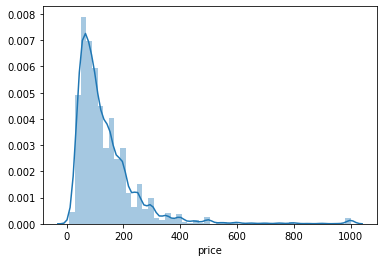

In [60]:
# check the price distribution
sns.distplot(df2['price'])

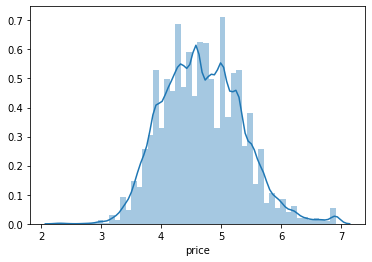

In [61]:
# convert to log scale
cols_to_log = ['price','accommodates','review_scores_rating','cleaning_fee',
              'host_listings_count',
               'availability_90',
              'extra_people',
              'number_of_reviews',
              'bathrooms',
              'security_deposit']

for col in cols_to_log:
    df2[col] = df2[col].astype('float64').replace(0.0, 0.01)
    df2[col] = np.log(df2[col])
    
sns.distplot(df2['price'])

# Xgboost Model

In [62]:
X = df2.drop('price', axis=1)
y = df2.price
# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Splitting into train and test sets
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 

In [64]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:45:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [66]:
# Evaluate
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Training MSE: 0.1365
Validation MSE: 0.1494

Training r2: 0.6835
Validation r2: 0.6573


In [67]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

weight
room_type_Entire home/apt               0.685094
neighbourhood_group_cleansed_Manhattan  0.045674
bathrooms                               0.039996
bedrooms                                0.027112
accommodates                            0.024526
cluster_cluster_1                       0.022556
cluster_cluster_2                       0.019765
room_type_Private room                  0.016966
cleaning_fee                            0.015161
Gym                                     0.011299

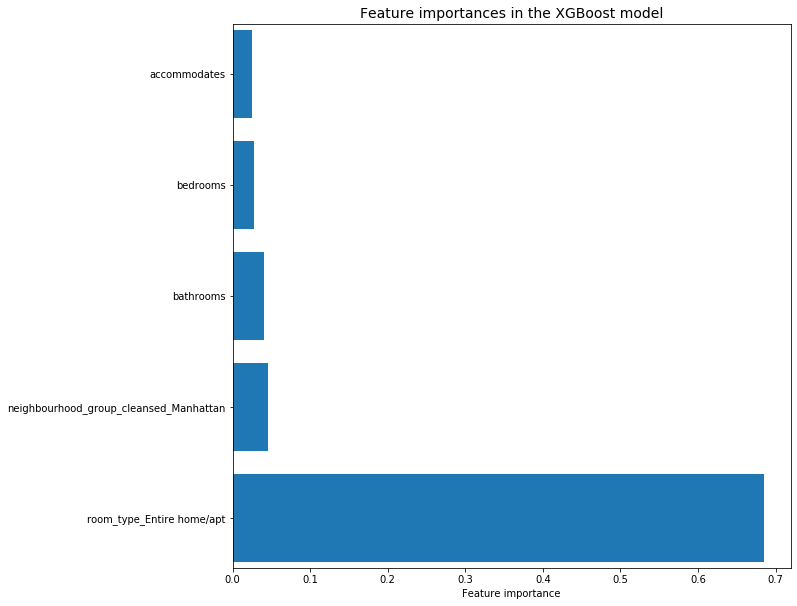

In [68]:
# Plotting feature importances
plt.figure(figsize=(10,10))
plt.barh(ft_weights_xgb_reg.index[:5], ft_weights_xgb_reg.weight[:5], align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

# Second Model

Only entire homes and appartments

In [69]:
df1['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [71]:
df1b = df1[df1['room_type'] == 'Entire home/apt']
df1b.drop(['room_type'], axis=1, inplace=True)
df1b.head()

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Unnamed: 0  price neighbourhood_group_cleansed  accommodates  \
0           0    225                    Manhattan             1   
1           2    200                    Manhattan             2   
5           6    150                    Manhattan             3   
7           9    120                    Manhattan             1   
8          10    140                     Brooklyn             3   

   review_scores_rating property_type  cleaning_fee  host_listings_count  \
0                  94.0     Apartment            95                  6.0   
1                  90.0     Apartment           125                  1.0   
5                  94.0     Apartment            40                  4.0   
7                  97.0     Apartment           150                  2.0   
8                  91.0     Apartment            90                  1.0   

   availability_90  extra_people  ...  Kitchen  Free parking on premises  Gym  \
0                1             0  ...        1                         0    0   
1               19           100  ...        1                         0    0   
5                1            10  ...        1                         0    0   
7               89            10  ...        1                         0    0   
8                0            20  ...        1                         0    0   

   Elevator  Hot tub  Washer  Laptop friendly workspace  Private entrance  \
0         0        0       0                          1                 0   
1         0        0       0                          1                 0   
5         0        0       0                          1                 0   
7         0        0       0                          1                 0   
8         0        0       1                          1                 0   

   cancellation_policy_flexible    cluster  
0                             0  cluster_2  
1                             0  cluster_2  
5                             0  cluster_2  
7                             0  cluster_2  
8                             0  cluster_2  

[5 rows x 29 columns]

In [72]:
# Fit the model again

df2 = pd.get_dummies(df1b)
cols_to_log = ['price','accommodates','review_scores_rating','cleaning_fee',
              'host_listings_count',
               'availability_90',
              'extra_people',
              'number_of_reviews',
              'bathrooms',
              'security_deposit']
for col in cols_to_log:
    df2[col] = df2[col].astype('float64').replace(0.0, 0.01)
    df2[col] = np.log(df2[col])
X = df2.drop('price', axis=1)
y = df2.price
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

/home/fede/anaconda3/envs/geopandas/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:47:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 0.1214
Validation MSE: 0.1342

Training r2: 0.5328
Validation r2: 0.5019


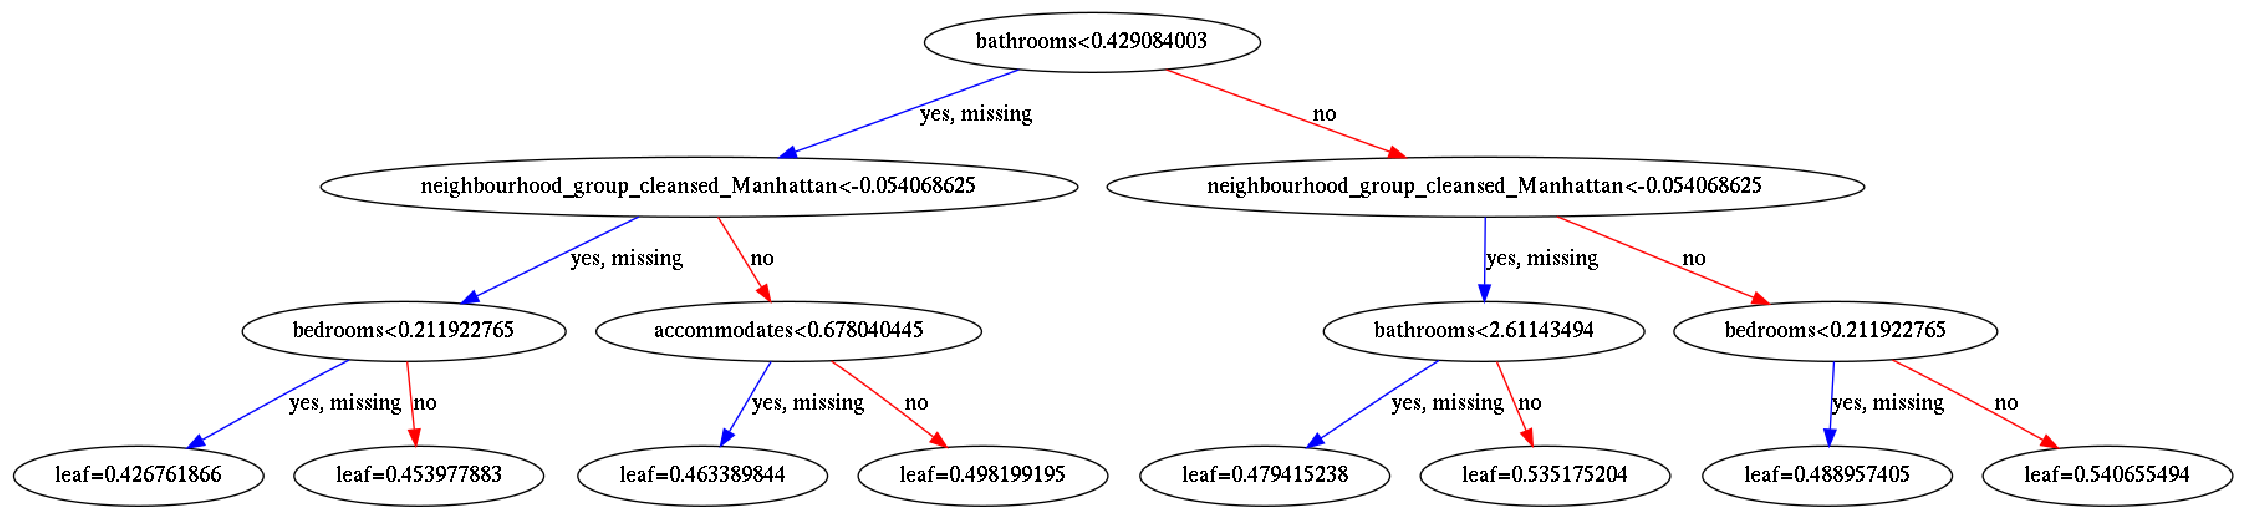

In [75]:
# visualize the trees
fig, ax = plt.subplots(figsize=(40, 100)) 
plot_tree(xgb_reg, ax=ax)
plt.show()

In [76]:
# check feature importance
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

weight
bathrooms                               0.221961
neighbourhood_group_cleansed_Manhattan  0.133364
cluster_cluster_2                       0.086609
bedrooms                                0.077351
cleaning_fee                            0.056482
accommodates                            0.054932
Washer                                  0.054882
Gym                                     0.042222
Elevator                                0.030286
neighbourhood_group_cleansed_Brooklyn   0.025463

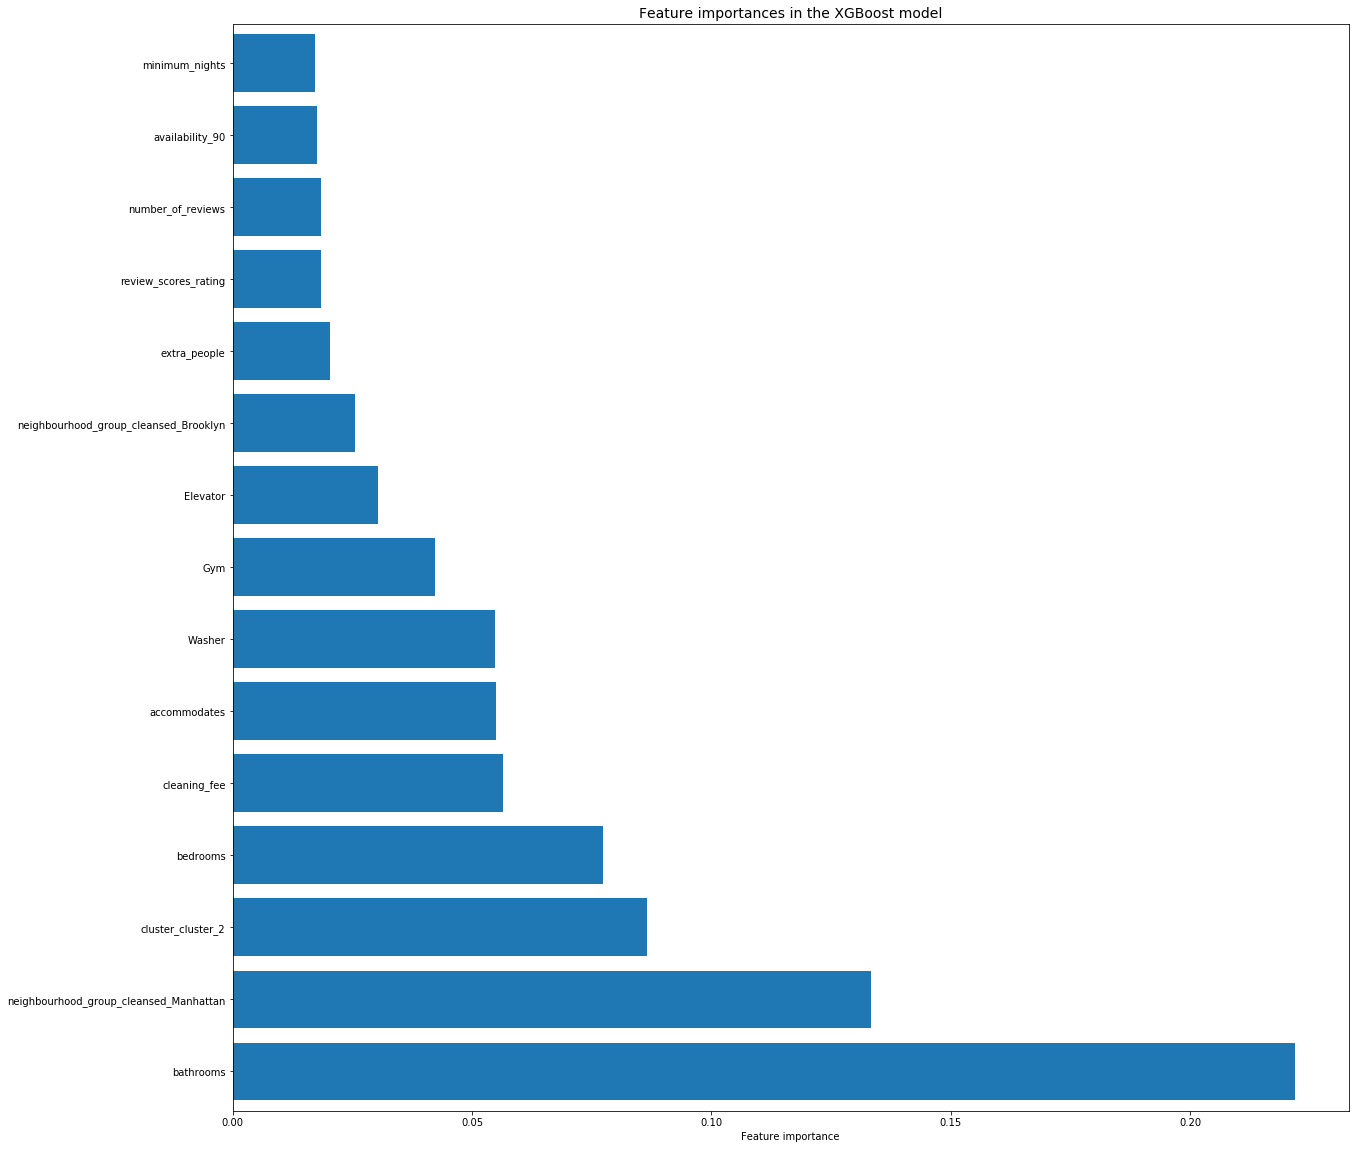

In [77]:
plt.figure(figsize=(20,20))
plt.barh(ft_weights_xgb_reg.index[:15], ft_weights_xgb_reg.weight[:15], align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

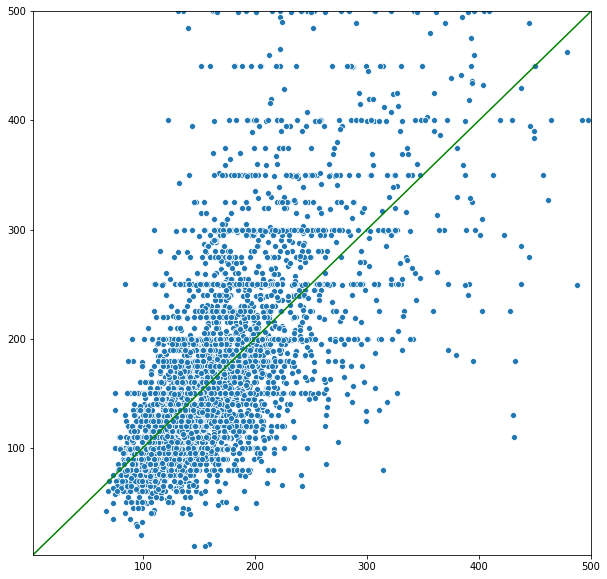

In [78]:
# convert from natural logarith back to original scale
predicted_prices = [np.e**i for i in val_preds_xgb_reg]
test_prices = [np.e**i for i in y_test.values]
plt.figure(figsize=(10,10))
plt.ylim(2,500)
plt.xlim(2,500)
sns.scatterplot(predicted_prices, test_prices)
sns.lineplot(range(500),range(500), color='g')

In [79]:
# Discussion

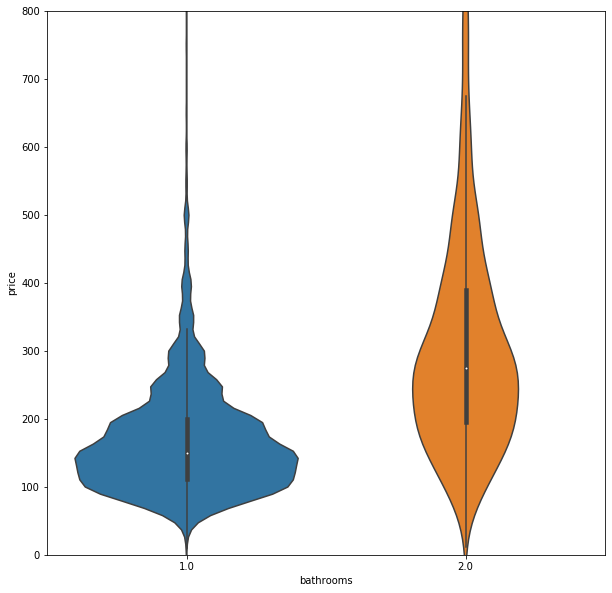

In [80]:
plt.figure(figsize=(10,10))
plt.ylim(0, 800)
tempdf2 = df1b[(df1b['bathrooms'] == 1) | (df1b['bathrooms'] == 2)]
sns.violinplot(data=tempdf2, x='bathrooms', y='price')

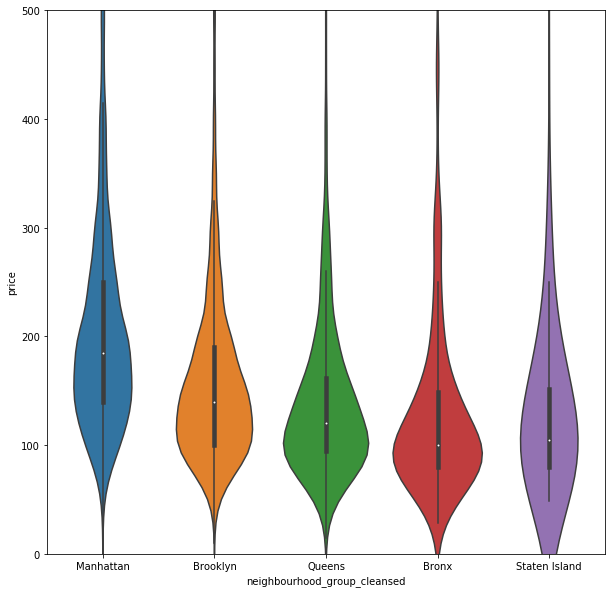

In [81]:
plt.figure(figsize=(10,10))
plt.ylim(0, 500)
tempdf2 = df1b
sns.violinplot(data=tempdf2, x='neighbourhood_group_cleansed', y='price')

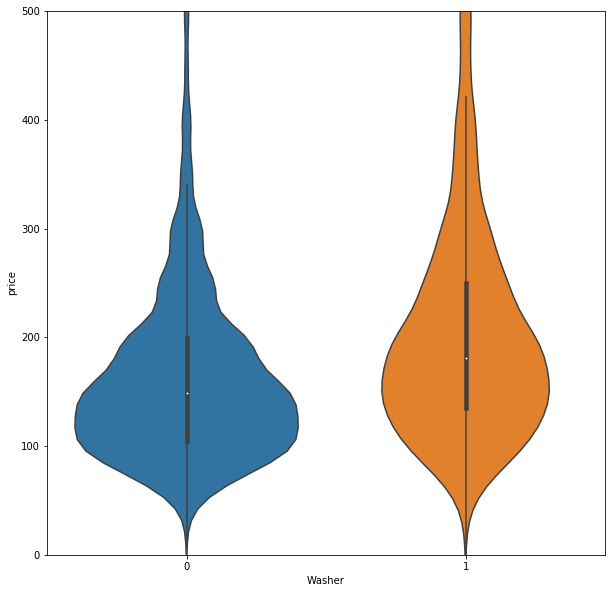

In [82]:
# wasing machine
plt.figure(figsize=(10,10))
plt.ylim(0, 500)
sns.violinplot(data=tempdf2, x='Washer', y='price')

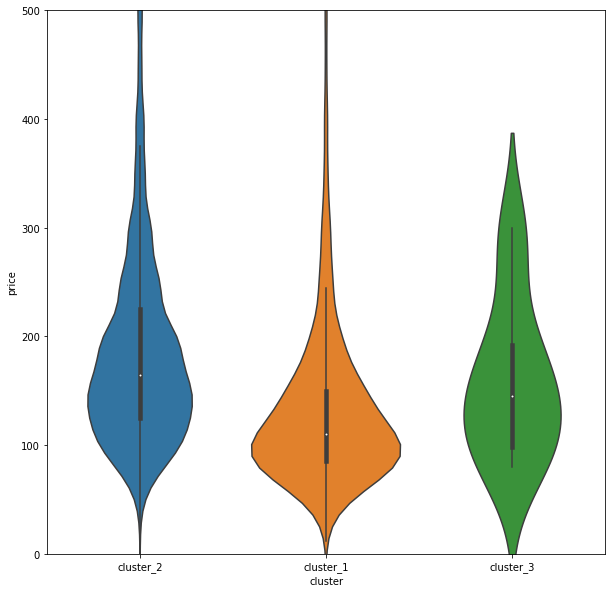

In [83]:
# cluster
tempdf2 = df1b[(df1b['cluster'] == 'cluster_1') | (df1b['cluster'] == 'cluster_2') | (df1b['cluster'] == 'cluster_3')]
plt.figure(figsize=(10,10))
plt.ylim(0, 500)
sns.violinplot(data=tempdf2, x='cluster', y='price')